In [1]:
# ========== Section 1: Install & Import Dependencies ==========

# 🛠️ Install required packages
!pip install -q optuna
!pip install -q umap-learn
!pip install -q tensorflow-addons

# 📦 Imports
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Lambda
)
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

print("✅ All dependencies installed and imported.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
✅ All dependencies installed and imported.


In [2]:
# ========== Section 2: Upload candump Logs ==========

from google.colab import files

print("📂 Please upload your 'normal.log' and 'attack.log' candump files.")
uploaded = files.upload()

# Map filenames
log_files = list(uploaded.keys())
normal_file = [f for f in log_files if 'normal' in f.lower()][0]
attack_file = [f for f in log_files if 'attack' in f.lower()][0]

print(f"✅ Files uploaded:\n - Normal: {normal_file}\n - Attack: {attack_file}")


📂 Please upload your 'normal.log' and 'attack.log' candump files.


Saving normal.log to normal.log
Saving attack.log to attack.log
✅ Files uploaded:
 - Normal: normal.log
 - Attack: attack.log


In [18]:
# ========== Section 3: Robust candump Parser ==========

def parse_candump(filename):
    """
    Parse a candump log into a DataFrame with timestamp, CAN ID, and bytes.
    Handles malformed lines and variable data lengths robustly.
    """
    parsed = []
    with open(filename, 'r') as f:
        for line in f:
            try:
                match = re.search(r"\(([\d\.]+)\)\s+(\w+)\s+([\dA-Fa-f]+)#([0-9A-Fa-f]*)", line)
                if match:
                    timestamp = float(match.group(1))
                    can_id = int(match.group(3), 16)
                    data = match.group(4)
                    byte_vals = [int(data[i:i+2], 16) for i in range(0, len(data), 2)]
                    parsed.append([timestamp, can_id] + byte_vals)
            except Exception as e:
                print(f"⚠️ Skipping malformed line: {line.strip()}\n   Reason: {e}")
                continue

    if not parsed:
        raise ValueError(f"No valid CAN data found in file {filename}")

    max_len = max(len(p) for p in parsed)
    cols = ['timestamp', 'can_id'] + [f'byte_{i}' for i in range(max_len - 2)]
    df = pd.DataFrame(parsed, columns=cols)
    return df

# Parse both logs
df_normal = parse_candump(normal_file)
df_attack = parse_candump(attack_file)

print(f"✅ Parsed Normal Log: {df_normal.shape[0]} messages")
print(f"✅ Parsed Attack Log: {df_attack.shape[0]} messages")




✅ Parsed Normal Log: 4303 messages
✅ Parsed Attack Log: 4353 messages


In [4]:
# ========== Section 4: Feature Engineering & Sequence Preparation ==========

def compute_entropy(row_bytes):
    """
    Compute Shannon entropy of the data bytes.
    """
    if len(row_bytes) == 0:
        return 0.0
    counts = np.bincount(row_bytes, minlength=256)
    probs = counts / np.sum(counts)
    return -np.sum(probs[probs > 0] * np.log2(probs[probs > 0]))

def preprocess_df(df):
    """
    Adds useful features like byte entropy and time delta.
    Normalizes byte values.
    """
    df = df.copy()
    df = df.sort_values('timestamp')
    df['timestamp_delta'] = df['timestamp'].diff().fillna(0)
    df['byte_entropy'] = df.iloc[:, 2:].apply(lambda row: compute_entropy(row.dropna().astype(int)), axis=1)

    # Fill missing byte columns with 0s
    byte_cols = [col for col in df.columns if col.startswith('byte_')]
    df[byte_cols] = df[byte_cols].fillna(0).astype(int)

    return df

def generate_sequences(df, sequence_length=10):
    """
    Generate overlapping sequences from DataFrame for LSTM-VAE input.
    Each sequence is shape: (sequence_length, features)
    """
    features = [col for col in df.columns if col not in ['timestamp', 'can_id']]
    data = df[features].values
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
    return np.array(sequences)

# Apply preprocessing
df_normal_proc = preprocess_df(df_normal)
df_attack_proc = preprocess_df(df_attack)

# Sequence parameters
SEQUENCE_LENGTH = 10

# Generate sequences
X_normal_seq = generate_sequences(df_normal_proc, sequence_length=SEQUENCE_LENGTH)
X_attack_seq = generate_sequences(df_attack_proc, sequence_length=SEQUENCE_LENGTH)

# Final shape check
print(f"📊 Normal Sequences: {X_normal_seq.shape}")
print(f"📊 Attack Sequences: {X_attack_seq.shape}")


📊 Normal Sequences: (4293, 10, 10)
📊 Attack Sequences: (4343, 10, 10)


In [6]:
# ========== Section 5 (Fixed): LSTM-VAE Model with KL Divergence Built-In ==========

class KLDivergenceLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        self.kl_loss = 0
        super(KLDivergenceLayer, self).__init__(**kwargs)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        self.kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        self.add_loss(self.kl_loss)
        return inputs

def build_lstm_vae_fixed(input_shape, latent_dim=16):
    timesteps, features = input_shape

    # Encoder
    inputs = Input(shape=(timesteps, features))
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(32)(x)

    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    z_mean, z_log_var = KLDivergenceLayer()([z_mean, z_log_var])
    z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

    # Decoder
    decoder_input = RepeatVector(timesteps)(z)
    x_dec = LSTM(32, return_sequences=True)(decoder_input)
    x_dec = LSTM(64, return_sequences=True)(x_dec)
    outputs = TimeDistributed(Dense(features))(x_dec)

    vae = Model(inputs, outputs, name="lstm_vae")
    vae.compile(optimizer="adam", loss="mse")
    return vae

# Build and train fixed model
vae = build_lstm_vae_fixed(INPUT_SHAPE, LATENT_DIM)
vae.summary()

history = vae.fit(
    X_normal_seq, X_normal_seq,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)


Model: "lstm_vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 10, 64)    │     19,200 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 32)        │     12,416 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │        528 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │        528 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kl_divergence_layer │ [(None, 16),      │          0 │ z_mean[0][0],     │
│ (KLDivergenceLayer) │ (None, 16)]       │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 16)        │          0 │ kl_divergence_la… │
│                     │                   │            │ kl_divergence_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 10, 16)    │          0 │ z[0][0]           │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 10, 32)    │      6,272 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 10, 64)    │     24,832 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 10, 10)    │        650 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 2101.3022 - val_loss: 2410.1047
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 1859.6658 - val_loss: 2391.3823
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1777.4330 - val_loss: 2382.9006
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1695.7382 - val_loss: 2382.9053
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1630.2455 - val_loss: 2380.4185
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1556.7512 - val_loss: 2385.6152
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 1500.7974 - val_loss: 2400.6836
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1452.1992 - val_loss: 2399.2336
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1392.6830 - val_loss: 2414.8066
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 1337.3143 - val_loss: 2431.4653


136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
🔍 Top 5 Suspicious CAN IDs (Hex format):
can_id
0x19b    5396.425705
0x244    3813.176818
0x188    3564.350938
Name: recon_error, dtype: float64


/tmp/ipython-input-8-563494056.py:39: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


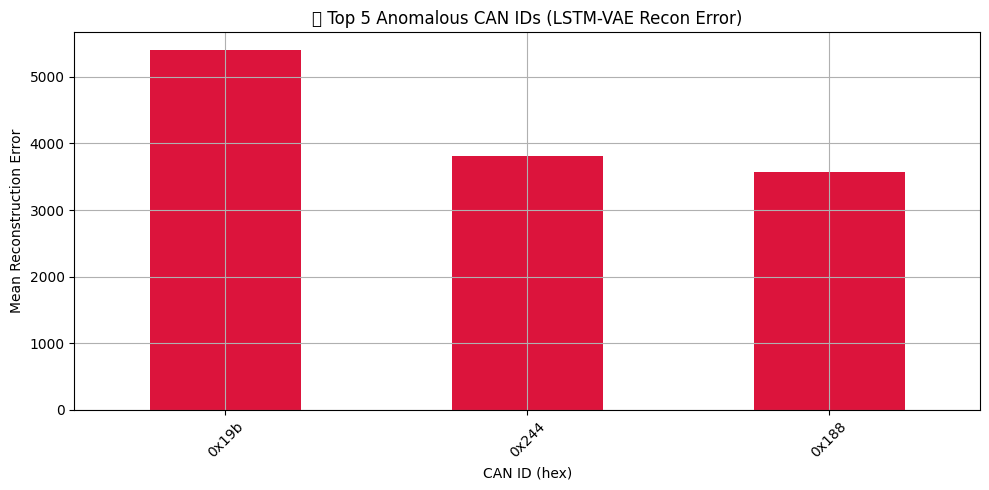

In [8]:
# ========== Section 6 (Updated): Predict Anomalies & Rank Suspicious CAN IDs ==========

# Predict reconstruction
X_pred = vae.predict(X_attack_seq)
recon_errors = np.mean(np.square(X_attack_seq - X_pred), axis=(1, 2))

# Align scores with CAN IDs
sequence_base_idx = np.arange(len(recon_errors))
base_indices = df_attack_proc.iloc[sequence_base_idx].index

df_scores = pd.DataFrame({
    'index': base_indices,
    'recon_error': recon_errors
})
df_scores.set_index('index', inplace=True)

# Merge scores to original CAN IDs
df_merged = df_attack_proc.merge(df_scores, left_index=True, right_index=True)

# Group and compute anomaly score per CAN ID
can_anomaly_scores = df_merged.groupby('can_id')['recon_error'].mean().sort_values(ascending=False)

# Format CAN ID as hex for visualization
can_anomaly_scores.index = can_anomaly_scores.index.map(lambda x: hex(int(x)))

# Display Top 5
top5_ids = can_anomaly_scores.head(5)
print("🔍 Top 5 Suspicious CAN IDs (Hex format):")
print(top5_ids)

# Plot
plt.figure(figsize=(10, 5))
top5_ids.plot(kind='bar', color='crimson')
plt.title("🚨 Top 5 Anomalous CAN IDs (LSTM-VAE Recon Error)")
plt.ylabel("Mean Reconstruction Error")
plt.xlabel("CAN ID (hex)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-9-149034065.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


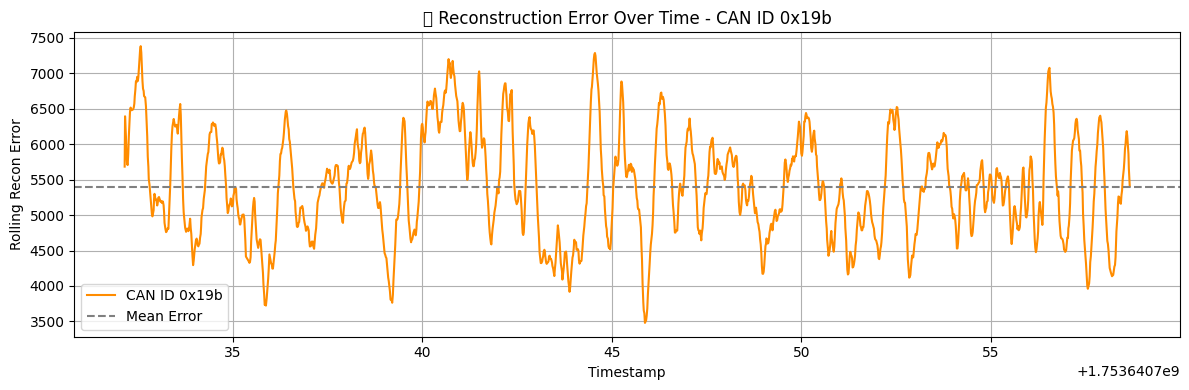

/tmp/ipython-input-9-149034065.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


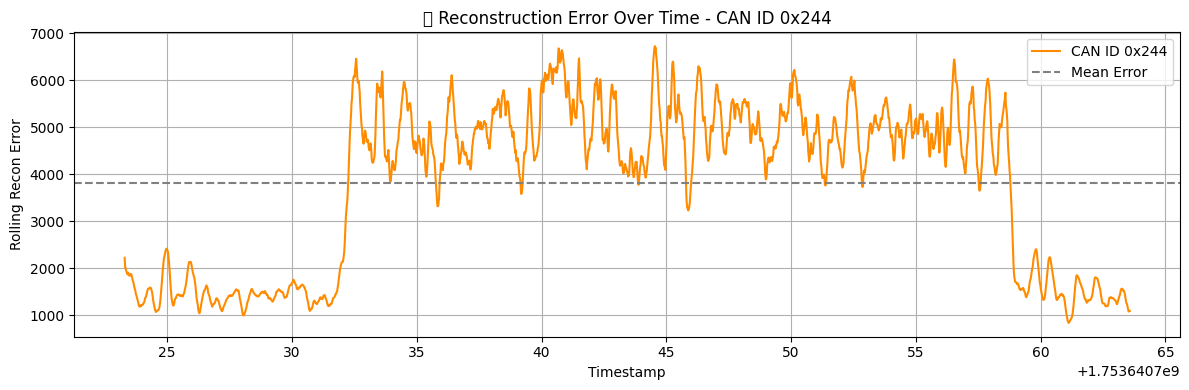

/tmp/ipython-input-9-149034065.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


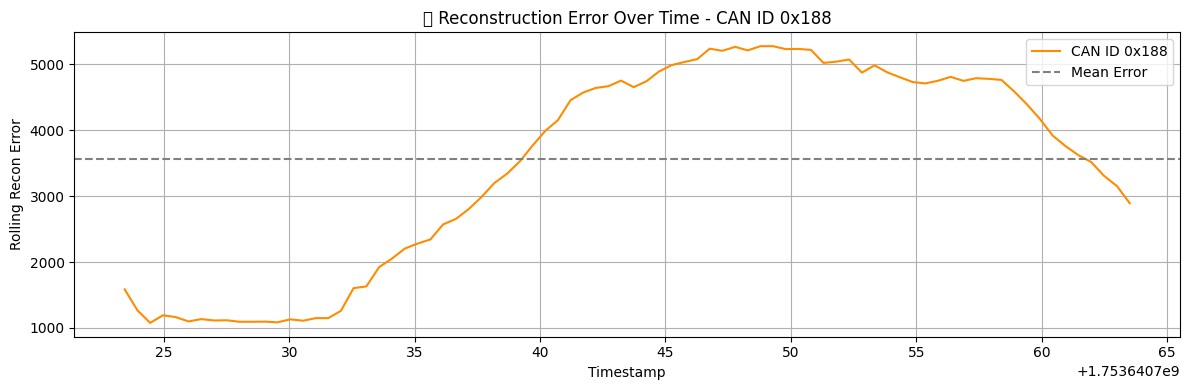

In [9]:
# ========== Section 7A: Time-Series Anomaly Plot per CAN ID ==========

def plot_reconstruction_errors_over_time(df_merged, can_id_hex, window_size=20):
    """
    Plot rolling reconstruction error over time for a specific CAN ID.
    """
    can_id_int = int(can_id_hex, 16)
    subset = df_merged[df_merged['can_id'] == can_id_int].copy()
    subset['rolling_error'] = subset['recon_error'].rolling(window=window_size, min_periods=1).mean()

    plt.figure(figsize=(12, 4))
    plt.plot(subset['timestamp'], subset['rolling_error'], label=f"CAN ID {can_id_hex}", color='darkorange')
    plt.axhline(y=subset['recon_error'].mean(), color='gray', linestyle='--', label='Mean Error')
    plt.title(f"📈 Reconstruction Error Over Time - CAN ID {can_id_hex}")
    plt.xlabel("Timestamp")
    plt.ylabel("Rolling Recon Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for top 5 CAN IDs (in hex)
for can_id_hex in top5_ids.index:
    plot_reconstruction_errors_over_time(df_merged, can_id_hex)


/tmp/ipython-input-10-352552726.py:20: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


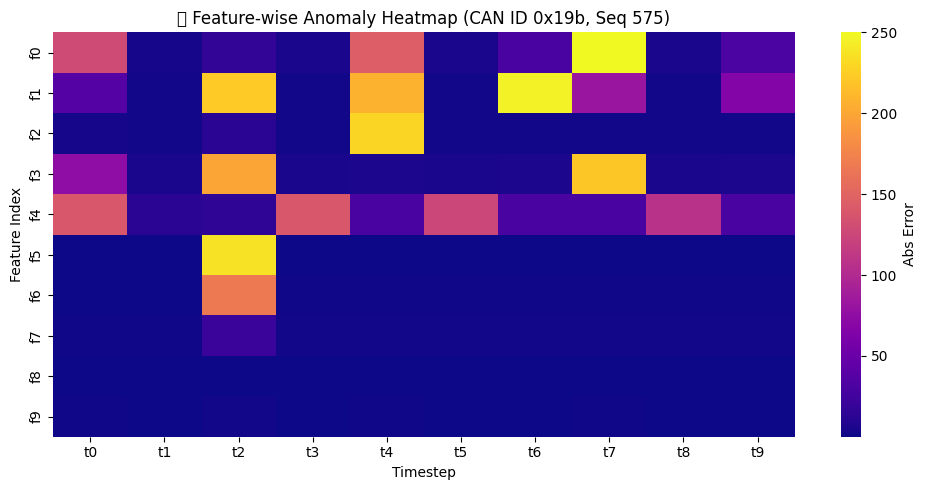

/tmp/ipython-input-10-352552726.py:20: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


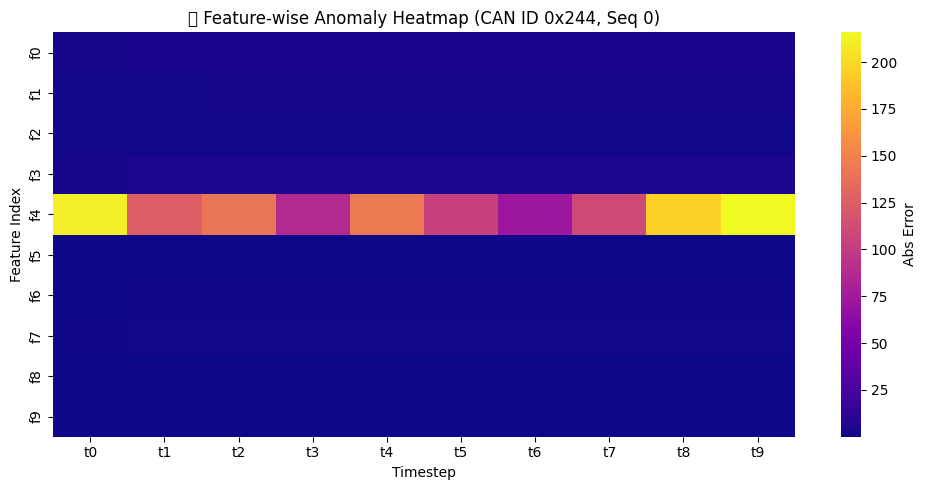

/tmp/ipython-input-10-352552726.py:20: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


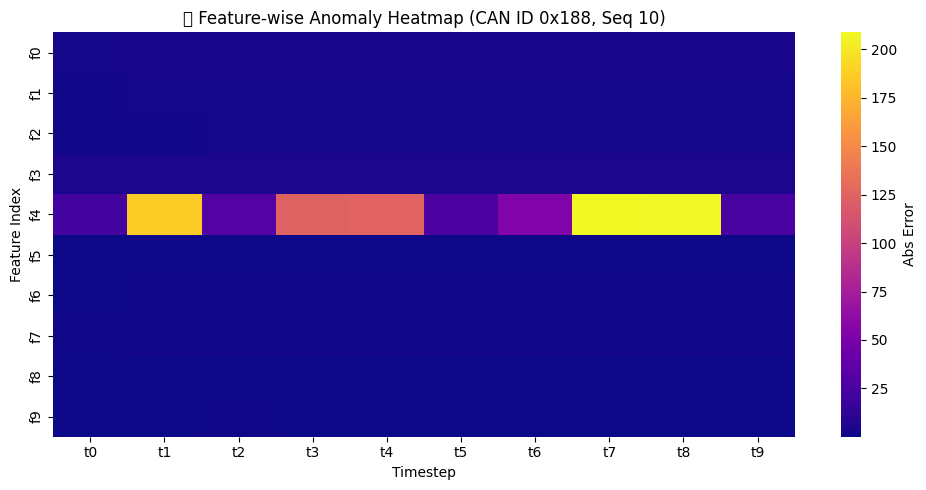

In [10]:
# ========== Section 7B: Feature-wise Heatmap for Top CAN IDs ==========

def plot_feature_heatmap(seq_true, seq_pred, can_id_hex, seq_idx):
    """
    Visualize feature-wise absolute error for one sequence as a heatmap.
    """
    error_matrix = np.abs(seq_true - seq_pred)

    plt.figure(figsize=(10, 5))
    sns.heatmap(
        error_matrix.T,
        cmap="plasma",
        xticklabels=[f"t{i}" for i in range(error_matrix.shape[0])],
        yticklabels=[f"f{i}" for i in range(error_matrix.shape[1])],
        cbar_kws={'label': 'Abs Error'}
    )
    plt.title(f"🔥 Feature-wise Anomaly Heatmap (CAN ID {can_id_hex}, Seq {seq_idx})")
    plt.xlabel("Timestep")
    plt.ylabel("Feature Index")
    plt.tight_layout()
    plt.show()

# Loop over Top 5 CAN IDs
for can_id_hex in top5_ids.index:
    can_id_int = int(can_id_hex, 16)
    idx_candidates = df_attack_proc[df_attack_proc['can_id'] == can_id_int].index

    # Use safest matching sequence index
    base_idx = idx_candidates[0]
    safe_seq_idx = max(0, min(base_idx, len(X_attack_seq)-1))

    plot_feature_heatmap(X_attack_seq[safe_seq_idx], X_pred[safe_seq_idx], can_id_hex, safe_seq_idx)


/tmp/ipython-input-11-3279437113.py:34: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


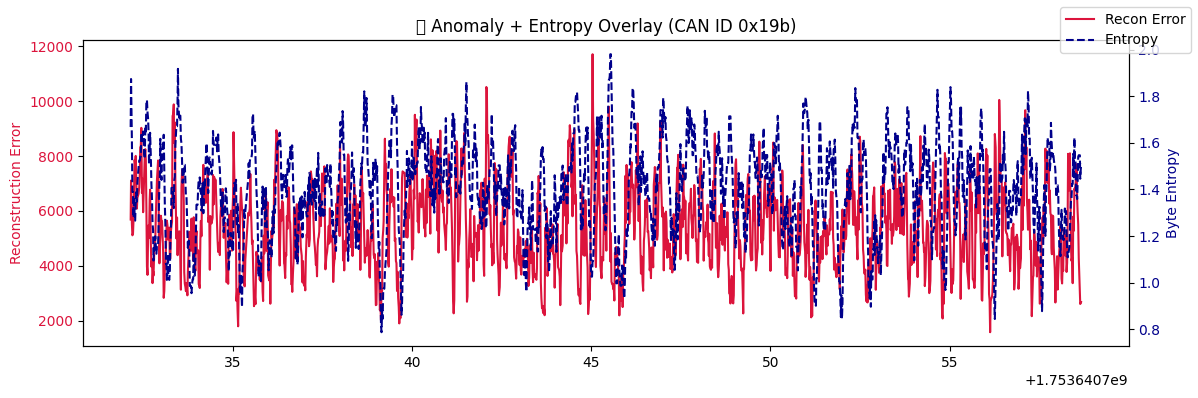

/tmp/ipython-input-11-3279437113.py:34: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


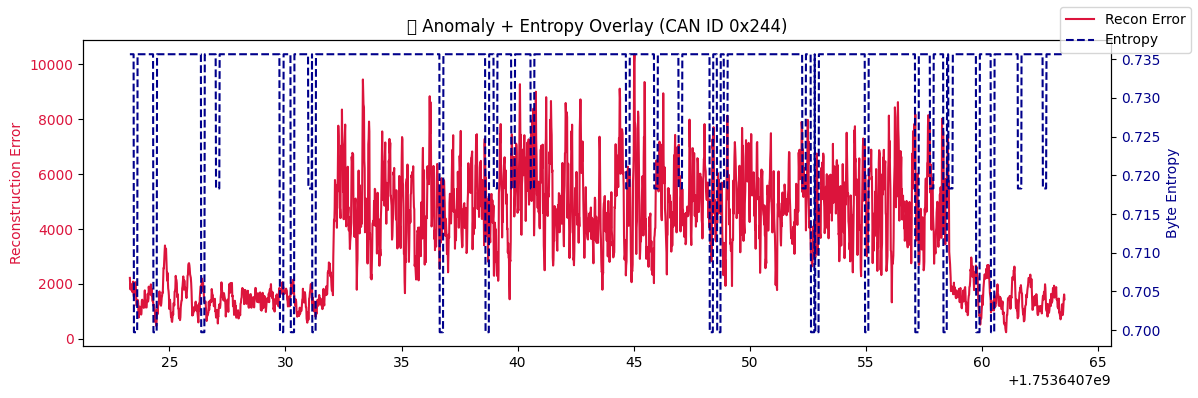

/tmp/ipython-input-11-3279437113.py:34: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


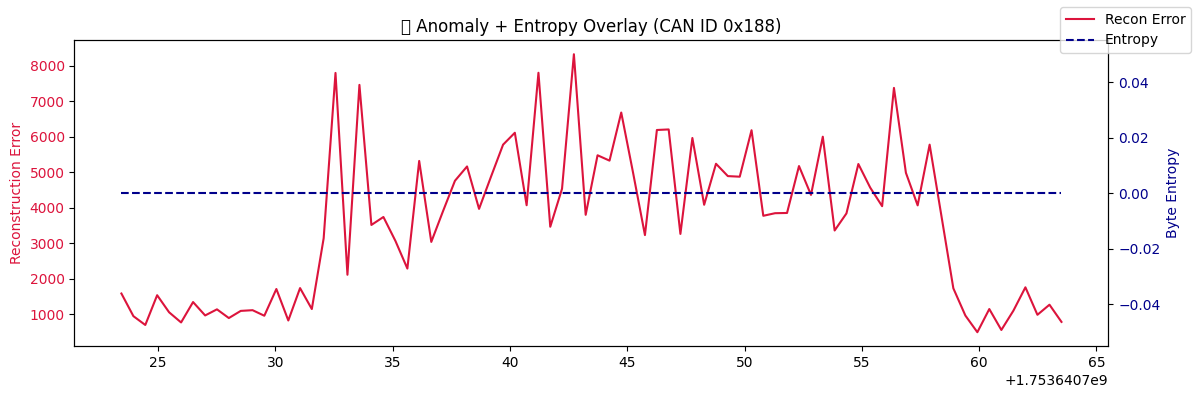

In [11]:
# ========== Section 7C: Entropy & Frequency Overlays per CAN ID ==========

from scipy.stats import entropy as calc_entropy
from collections import Counter

def compute_entropy_and_freq(seq_bytes):
    """Compute Shannon entropy and frequency of bytes."""
    counts = Counter(seq_bytes)
    prob_dist = np.array(list(counts.values())) / len(seq_bytes)
    return calc_entropy(prob_dist), counts

def plot_behavioral_overlay(df, can_id_hex):
    can_id_int = int(can_id_hex, 16)
    subset = df[df['can_id'] == can_id_int].copy()

    # Calculate rolling entropy
    subset['entropy'] = subset.iloc[:, 2:10].apply(lambda row: calc_entropy(np.bincount(row.astype(int), minlength=256) / 8), axis=1)
    subset['rolling_entropy'] = subset['entropy'].rolling(window=10, min_periods=1).mean()

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 4))

    ax1.plot(subset['timestamp'], subset['recon_error'], color='crimson', label='Recon Error')
    ax1.set_ylabel("Reconstruction Error", color='crimson')
    ax1.tick_params(axis='y', labelcolor='crimson')

    ax2 = ax1.twinx()
    ax2.plot(subset['timestamp'], subset['rolling_entropy'], color='darkblue', label='Entropy', linestyle='--')
    ax2.set_ylabel("Byte Entropy", color='darkblue')
    ax2.tick_params(axis='y', labelcolor='darkblue')

    plt.title(f"🔍 Anomaly + Entropy Overlay (CAN ID {can_id_hex})")
    fig.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Plot overlays for top 5
for can_id_hex in top5_ids.index:
    plot_behavioral_overlay(df_merged, can_id_hex)


🧮 Dynamic thresholds computed per CAN ID.


/tmp/ipython-input-16-3549232867.py:50: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


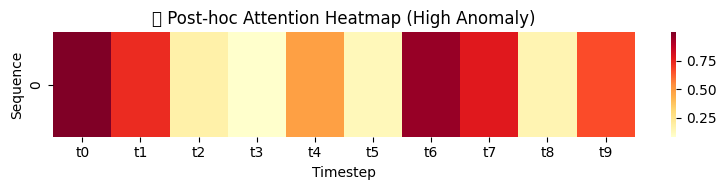

⚙️ Extracting latent z_mean from encoder...


/tmp/ipython-input-16-3549232867.py:75: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


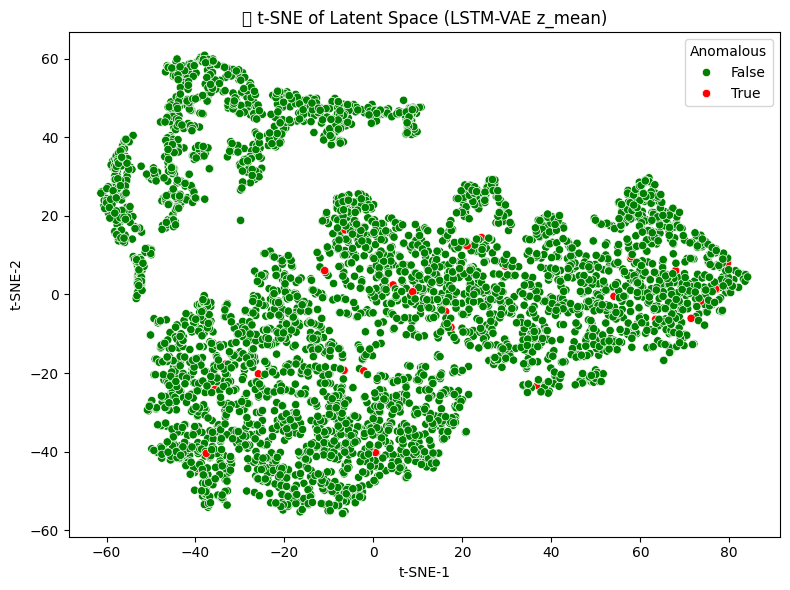

In [16]:
# ========== Fixed Section 8A–8D: All Enhancements ==========

from sklearn.manifold import TSNE
from tensorflow.keras.models import Model

def section8_all_modules(df_merged, df_attack_proc, X_attack_seq, X_pred, ae_recon_error=None):
    """
    Combines:
    8A - Dynamic thresholds per CAN ID
    8B - Post-hoc attention heatmaps
    8C - Ensemble anomaly score (if AE is provided)
    8D - t-SNE latent visualization using encoder z_mean
    """

    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    output = {}

    # ===== 8A: Dynamic Thresholding =====
    def compute_dynamic_thresholds(df_proc, score_column='recon_error', quantile=0.99):
        thresholds = df_proc.groupby('can_id')[score_column].quantile(quantile)
        print("🧮 Dynamic thresholds computed per CAN ID.")
        return thresholds

    dynamic_thresh = compute_dynamic_thresholds(df_merged, score_column='recon_error')
    df_merged['is_anomalous'] = df_merged.apply(
        lambda row: row['recon_error'] > dynamic_thresh.get(row['can_id'], np.inf),
        axis=1
    )
    output['dynamic_thresholds'] = dynamic_thresh

    # ===== 8B: Post-hoc Attention Heatmap =====
    def posthoc_attention(recon_errors):
        attention_weights = np.mean(np.abs(recon_errors), axis=2)
        attention_weights = attention_weights / (attention_weights.max(axis=1, keepdims=True) + 1e-6)
        return attention_weights

    attention_weights = posthoc_attention(X_attack_seq - X_pred)
    output['attention_weights'] = attention_weights

    # Plot attention heatmap for top anomaly
    top_idx = np.argmax(df_merged['recon_error'].values)
    plt.figure(figsize=(8, 2))
    sns.heatmap(attention_weights[top_idx:top_idx+1], cmap='YlOrRd', xticklabels=[f"t{i}" for i in range(attention_weights.shape[1])])
    plt.title("🧠 Post-hoc Attention Heatmap (High Anomaly)")
    plt.ylabel("Sequence")
    plt.xlabel("Timestep")
    plt.tight_layout()
    plt.show()

    # ===== 8C: Ensemble Score (if AE is available) =====
    if ae_recon_error is not None and len(ae_recon_error) == len(df_merged):
        df_merged['ensemble_score'] = (df_merged['recon_error'] + ae_recon_error) / 2.0
        print("🧪 Ensemble anomaly score added.")
        output['ensemble'] = df_merged['ensemble_score']

    # ===== 8D: t-SNE of Latent Space =====
    print("⚙️ Extracting latent z_mean from encoder...")
    try:
        encoder = Model(inputs=vae.input, outputs=vae.get_layer("z_mean").output)
        z_vals = encoder.predict(X_attack_seq, verbose=0)
        output['z_mean'] = z_vals

        tsne = TSNE(n_components=2, random_state=42)
        z_2d = tsne.fit_transform(z_vals)

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=df_merged['is_anomalous'], palette={True: 'red', False: 'green'})
        plt.title("🎯 t-SNE of Latent Space (LSTM-VAE z_mean)")
        plt.xlabel("t-SNE-1")
        plt.ylabel("t-SNE-2")
        plt.legend(title='Anomalous')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("❌ Could not compute t-SNE:", e)

    return df_merged, output

df_merged_updated, enhancements_output = section8_all_modules(
    df_merged, df_attack_proc, X_attack_seq, X_pred
)
